**The action space here are the variables themselves. At each step we only look at values from the regressor for variables that are still available**

In [2]:
%matplotlib inline

from collections import defaultdict
from queue import Queue

import matplotlib.pyplot as plt
import numpy as np
import os

import pickle
import time

from random import shuffle
from itertools import combinations
from scipy.special import comb

In [3]:
switch_literal = lambda x: x[1:] if x.startswith('-') else '-'+x
deepcopy = lambda x: pickle.loads(pickle.dumps(x))

def parse_input(input_file):
    
    """
    literal_clauseNum: {Literal: Set of clause numbers that are still in consideration for this variable}                        
    
    clauseNum_clause: {Clause number: Set of literals that could still satisfy this clause}
    
    literal_boolen: {Literal: boolean on whether literal set of True/False/None, None meaning could be either, doesn't matter}
    
    input_file:
    c DIMACS CNF: conjunction/AND of one or more clauses, where a clause is a disjunction/OR of literals
    c Comments start with a c, First lines begins with p and describes the probelm and all clause lines end with a 0
    c Can't have same variable in both forms in same clause. So A ~A is not allowed. Can have them in separate clauses.
                        
    """

    all_clauses = []  # List of all clauses that appear in input. Used for SAT checking the mapping given by DPLL

    literal_clauseNum = defaultdict(set)

    def filler():
        return None

    literal_boolen = defaultdict(filler)

    clauseNum_clause = {}

    clause_counter = 0

    with open(input_file, 'r') as fin:
        for line in fin:
            line = line.strip()
            # Do checks on comments
            if line.startswith('c') or line.startswith('p') or line.startswith('0') or line.startswith('%'):
                continue
            if len(line) > 0:
                clause = []
                clause_counter += 1
                for literal in line.split():
                    if literal == '0':
                        # End of line, ignore in DIMACS CNF format
                        continue
                    clause.append(literal)
                    literal_clauseNum[literal].add(clause_counter)
                clauseNum_clause[clause_counter] = set(clause)
                all_clauses.append(clause)

    return literal_clauseNum, clauseNum_clause, literal_boolen, all_clauses

def unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen):
    keep_updating = True
    while keep_updating:
        keep_updating = False # Assuming we've found all unit clauses
        for clauseNum in list(clauseNum_clause.keys()):
            if clauseNum not in clauseNum_clause:
                continue
            clause = clauseNum_clause[clauseNum]
            # Clause contains the remaining literals that could potentially satisfy this clause. 
            if len(clause) == 0:
                # Empty clause, so need to return True for empty clause detected
                return True, None, None, None
            if len(clause) > 1:
                # Can't do unit prop 
                continue

            literal = clause.pop()  # Needs to be set to True
            clause.add(literal)  # Removed later
            literal_boolen[literal] = True
            keep_updating = True  # Since we found one unit clause, maybe more

    #         print(literal)
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)

            # For all clauses that have this literal, they have been satisfied now
            # 1) Gather all pairs of (literals, clauseNum) that appear in these clauses so we can remove them from literal_clauseNum
            # 2) Delete these clauses from clauseNum_clause
            pairs_to_delete = []
            for clauseNums_with_literal in literal_clauseNum[literal]:
                for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                    pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

            for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                if clauseNums_with_literal in clauseNum_clause:
                    del clauseNum_clause[clauseNums_with_literal]

            # For all the clauses with opposite literal, remove the literal from the clause
            if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
                continue

            opposite_literal = switch_literal(literal)
            literal_boolen[opposite_literal] = False

            for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
                clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

            literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
        
    return False, literal_clauseNum, clauseNum_clause, literal_boolen


def pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen):
    for literal in list(literal_clauseNum.keys()):
        if literal in literal_boolen:
            continue
        
        opposite_literal = switch_literal(literal)
        if opposite_literal not in literal_boolen: # The opposite variable has not been assigned yet
            # If it doesn't exist or it does but it doesn't have to satisfy any clauses
            if opposite_literal not in literal_clauseNum or len(literal_clauseNum[opposite_literal]) == 0:
                # LITERAL IS A PURE LITERAL
                literal_boolen[literal] = True
                
                # All the clauses that literal exists in has been made true, so remove the clauses and make literal watch no clause
                pairs_to_delete = []
                for clauseNums_with_literal in literal_clauseNum[literal]:
                    for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
                        pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

        #         print(pairs_to_delete)

                for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
                    literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
                    if clauseNums_with_literal in clauseNum_clause:
                        del clauseNum_clause[clauseNums_with_literal]
                        
    return literal_clauseNum, clauseNum_clause, literal_boolen


def maxo(literal_clauseNum, return_counts=False):
    """
    Returns the literal that appears in the most number of clauses
    """
    literal_count = defaultdict(int)
    for literal, clauseNums in literal_clauseNum.items():
        literal_count[literal] = len(clauseNums)
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def moms(literal_clauseNum, clauseNum_clause, return_counts=False):
    """
    Returns the literal that appears most in the smallest clauses
    """
    # Select the clausesNumbers for clauses of the smaller size
    least_size = min(map(len, clauseNum_clause.values()))
    literal_count = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            if len(clauseNum_clause[clauseNum]) == least_size:
                # Each time a literal appears in a least-size clause we 
                # increment counter by 1
                literal_count[literal] += 1
    
    if return_counts:
        return literal_count
    
    max_lit = None
    max_count = 0
    for literal, count in literal_count.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    return max_lit, max_count


def mams(literal_clauseNum, clauseNum_clause):
    """
    Combines MAXO and MOMS count statistics from above and chooses the literal that appears most between them
    """
    maxo_ans = maxo(literal_clauseNum, return_counts=True)
    moms_ans = moms(literal_clauseNum, clauseNum_clause, return_counts=True)
    
    # MAXO would return the dict with most keys
    for literal in maxo_ans:
        maxo_ans[literal] += moms_ans[literal]
        # Since using defaultdict we add 0 if literal not in moms_ans
    
    max_lit = None
    max_count = 0
    for literal, count in maxo_ans.items():
        if count > max_count:
            max_count = count
            max_lit = literal
    
    return max_lit, max_count


def jw(literal_clauseNum, clauseNum_clause):
    """
    Jeroslow-Wang Rule
    """
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in literal_score.items():
        if score > max_score:
            max_score = score
            max_lit = literal
            
    return max_lit, max_score

def jw_2(literal_clauseNum, clauseNum_clause):
    """
    2-sided JW rule. See Heutistics folder
    """
    
    literal_score = defaultdict(int)
    
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            clause = clauseNum_clause[clauseNum]
            literal_score[literal] += 2 ** -len(clause)
    
    max_lit = None
    max_score = 0
    for literal, score in list(literal_score.items()):
        other_literal = switch_literal(literal)
        total_score = score + literal_score[other_literal]
        
        if total_score > max_score:
            max_score = score
            max_lit = literal if score >= literal_score[other_literal] else other_literal
            
    return max_lit, max_score


def bohm(literal_clauseNum, clauseNum_clause):
    """
    See Heuristics folder. Lexicographic order of the vector (H1(x), H2(x), ..., Hn(x)) means we first choose highest H1(x)
    variable. When tied we then choose amongst tied variable highest H2 variable. When tied then H3 and so on.
    
    We've had to manage edge cases here but don't mention that in report. Only give formula from paper
    """
    pos_literal_count = defaultdict(lambda: [0, 0, 0])  # This default initialisation only works for 3 SAT
    neg_literal_count = defaultdict(lambda: [0, 0, 0])
    
    for literal, clauseNums in literal_clauseNum.items():
        if literal.startswith('-'):
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                neg_literal_count[literal][len(clause)-1] += 1
        else:
            for clauseNum in clauseNums:
                clause = clauseNum_clause[clauseNum]
                pos_literal_count[literal][len(clause)-1] += 1
                
    final_count = []
    # Sometimes we only have negative literals left. So then we just use those
    for literal, pos_counts in (pos_literal_count.items() or neg_literal_count.items()):
        other_literal = switch_literal(literal)
        
        if literal.startswith('-'):
            # pos_literal_counts is empty. So literal and pos_counts actually are neg_literal_counts
            neg_counts = pos_literal_count[other_literal]
        else:
            # pos_literal_counts isn't empty. So continue as normal
            neg_counts = neg_literal_count[other_literal]
        
        final_count.append(([max(p, n) + 2 * min(p, n) for p, n in zip(pos_counts, neg_counts)], literal))
            
    final_count.sort(reverse=True)
    score_vector, literal = final_count[0]
    other_literal = switch_literal(literal)
    
    if literal.startswith('-'):
        neg_literal = literal
        pos_literal = other_literal
    else:
        neg_literal = other_literal
        pos_literal = literal
    
    # Since the score for positive and negative literal is the same, choose one which the highest overall score
    if sum(pos_literal_count[pos_literal]) >= sum(neg_literal_count[neg_literal]):
        literal = pos_literal
    else:
        literal = neg_literal
    
    return literal, score_vector
    

def set_var(literal, boolean, literal_clauseNum, clauseNum_clause, literal_boolen):
    literal_boolen[literal] = boolean

    if boolean == False:
        literal = switch_literal(literal)
        literal_boolen[literal] = True
    
    # Unit-prop logic below
    pairs_to_delete = []
    for clauseNums_with_literal in literal_clauseNum[literal]:
        for literals_in_clauseNums in clauseNum_clause[clauseNums_with_literal]:
            pairs_to_delete.append((literals_in_clauseNums, clauseNums_with_literal))

    #         print(pairs_to_delete)

    for literals_in_clauseNums, clauseNums_with_literal in pairs_to_delete:
        literal_clauseNum[literals_in_clauseNums].discard(clauseNums_with_literal)
        if clauseNums_with_literal in clauseNum_clause:
            del clauseNum_clause[clauseNums_with_literal]

    # For all the clauses with opposite literal, remove the literal from the clause
    if switch_literal(literal) not in literal_clauseNum: # if the opposite variable doesn't exist, skip
        return literal_clauseNum, clauseNum_clause, literal_boolen

    opposite_literal = switch_literal(literal)
    literal_boolen[opposite_literal] = False

    for clauseNums_with_literal in literal_clauseNum[opposite_literal]:
        clauseNum_clause[clauseNums_with_literal].discard(opposite_literal)

    literal_clauseNum[opposite_literal] = set()  # It is not watching any clauses anymore

    #         print("OPPO")
    #         print(literal_clauseNum)
    #         print(clauseNum_clause)
    
    return literal_clauseNum, clauseNum_clause, literal_boolen

def choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo='maxo'):
    # Choosing the first literal every time
#     remaining_clauses = list(clauseNum_clause.values())
#     literal = remaining_clauses[0].pop()
#     remaining_clauses[0].add(literal)

    # Using heuristics
    if algo == 'maxo':
        literal, _ = maxo(literal_clauseNum)
    elif algo == 'moms':
        literal, _ = moms(literal_clauseNum, clauseNum_clause)
    elif algo == 'mams':
        literal, _ = mams(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw':
        literal, _ = jw(literal_clauseNum, clauseNum_clause)
    elif algo == 'jw_2':
        literal, _ = jw_2(literal_clauseNum, clauseNum_clause)
    elif algo == 'bohm':
        literal, _ = bohm(literal_clauseNum, clauseNum_clause)
    

    return literal

In [4]:
# Methods that are used by the Env class to get state features

def number_of_clauses(literal_clauseNum):
    """ Returns the number of clauses each of the literal is present in """
    ans = np.zeros(actions)
    for literal, clauseNums in literal_clauseNum.items():
        ans[LIT_IDX[literal]] = len(clauseNums)
    return ans


def number_of_horn_clauses(clauseNum_clause):
    """ Returns the number of horn clauses each literal is present in """
    ans = np.zeros(actions)
    for clause in clauseNum_clause.values():
        if len(clause) == 0:
            continue
        pos_literals = list(filter(lambda x: not x.startswith('-'), clause))
        if len(pos_literals) == 1:
            ans[LIT_IDX[pos_literals[0]]] += 1
            
    return ans
        


def CVIG(literal_clauseNum, clauseNum_clause):
    """
    Caluse-variable incidence graph. We create a bipartite graph (a matrix) with literals in rows and clauses in columns.
    See Features_2 PDF file.
    """
    
    clauseNum_index_mapping = {}
    
    for i, clauseNum in enumerate(clauseNum_clause):
        clauseNum_index_mapping[clauseNum] = i
        
    if len(clauseNum_clause) == 0:
        return np.zeros((len(LIT_IDX), 1))
    
    graph = np.zeros((len(LIT_IDX), len(clauseNum_index_mapping)))
    for literal, clauseNums in literal_clauseNum.items():
        for clauseNum in clauseNums:
            graph[LIT_IDX[literal]] [clauseNum_index_mapping[clauseNum]] = 1/len(clauseNums)
    
    return graph


def VIG(literal_clauseNum, clauseNum_clause):
    """
    Variable incidence graph.
    """
    if len(clauseNum_clause) == 0:
        return np.zeros((actions, actions))
    
    graph = np.zeros((actions, actions))
    
    for clause in clauseNum_clause.values():
        if len(clause) < 2:
            continue
        for x, y in combinations(clause, 2):
            w = 1 / (comb(len(clause), 2))  # Try combinations with replacement to add self-loops
            graph[LIT_IDX[x]][LIT_IDX[y]] = w
            graph[LIT_IDX[y]][LIT_IDX[x]] = w
            
    return graph

In [5]:
# env = Env('../Tests/SATLIB_20/uf20-026.cnf')
# print(env.reset())
# while True:
#     _, _, done = env.step(4)
#     if done:
#         break
#     print(env.get_state())
#     a, b, c = env.state
#     print(jw_2(a, b))

In [46]:
class Env:
    
    def __init__(self, input_file):
        self.input_file = input_file
        self.stack = [] # We use a stack to hold the next states to explore. i.e. we do DFS as less memory requirements than BFS
        self.state = None
        # self.actions = {0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}
        # self.action_penalty = {0: 0, 1: 0, 2: 0, 3: 0, 4: -1, 5: -1}  # Penalty to give each action
    
    def reset(self):
        # Returns state
        literal_clauseNum, clauseNum_clause, literal_boolen, _ = parse_input(self.input_file)
        self.state = (literal_clauseNum, clauseNum_clause, literal_boolen)
        return self.get_state()
    
    def get_state(self):
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses = number_of_clauses(literal_clauseNum)  # Equivalent to the number of variables present
        num_horn_clauses = number_of_horn_clauses(clauseNum_clause)
        
        vig_graph = VIG(literal_clauseNum, clauseNum_clause)
        vig_mean, vig_var = np.mean(vig_graph, axis=0), np.var(vig_graph, axis=0)
        
        cvig_graph = CVIG(literal_clauseNum, clauseNum_clause)
        cvig_mean, cvig_var = np.mean(cvig_graph, axis=1), np.var(cvig_graph, axis=1)
        
#         state_matrix = list(zip(num_clauses, num_horn_clauses, vig_mean, vig_var, cvig_mean, cvig_var))
        state_matrix = list(zip(num_clauses, num_horn_clauses, cvig_mean, cvig_var))
        
        return np.array(state_matrix)  # Returns a 2D array where each row corresponds to the metrics of a literal
    
#         num_var = number_of_variables(literal_clauseNum)
#         horn_clause = horn_clause_ratio(clauseNum_clause)
#         var_horn_counts = horn_clause_count(literal_clauseNum, clauseNum_clause)
#         var_horn_mean, var_horn_var = np.mean(var_horn_counts), np.var(var_horn_counts)
        
#         pn_ratio = pos_neg_ratio(literal_clauseNum)
#         c_v_ratio = clause_to_variable_ratio(literal_clauseNum)
        
#         cvig_graph = CVIG(literal_clauseNum, clauseNum_clause)
#         cvig_mean, cvig_var = np.mean(cvig_graph), np.var(cvig_graph)  # axis=0 gives more different results if we want this to return vector
        
        
    def step(self, action):
        """
        Returns: next_state_1, next_state_2, reward, done
        reward = 0 if reached a leaf node, 0 if not
        """
        literal_clauseNum, clauseNum_clause, literal_boolen = self.state
        
        num_clauses_start = 0
        for clause in clauseNum_clause.values():
            if len(clause) > 0:
                num_clauses_start += 1
                
        if num_clauses_start > 0:
            fraction_of_clauses_removed = num_clauses_start/num_clauses_start
        else:
            fraction_of_clauses_removed = 0
        
        unassigned_nodes_start = len(list(filter(lambda x: len(x) > 0, literal_clauseNum.values())))
        
        # Do unit prop
        empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = \
            unit_prop(literal_clauseNum, clauseNum_clause, literal_boolen)
            
        if empty_clause:
            isEmpty = len(self.stack) == 0
            if not isEmpty:
                self.state = self.stack.pop()
#             return None, -1 + fraction_of_clauses_removed, isEmpty
            return None, -1 , isEmpty
        
        if clauseNum_clause == {}:
#             return None, 1 + fraction_of_clauses_removed, True
            return None, 1, True

        # Do pure literal elimination
        literal_clauseNum, clauseNum_clause, literal_boolen = \
            pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
            
        if clauseNum_clause == {}:
#             return None, 1 + fraction_of_clauses_removed, True
            return None, 1, True
        
#         literal = choose_var(literal_clauseNum, clauseNum_clause, literal_boolen, algo=self.actions[action])
        literal = action
        
        # Set the chosen literal to be True
        literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T = \
            set_var(literal, True, deepcopy(literal_clauseNum), deepcopy(clauseNum_clause), dict(literal_boolen))
            
#         print("After setting", literal, "to True")
#         print(literal_clauseNum_T)
#         print(literal_boolen_T)
#         print()
        
#         unassigned_nodes_T = len(filter(lambda x: len(x) > 0, literal_clauseNum_T.values()))
        
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True
        
        # Set new state
        self.state = (literal_clauseNum_T, clauseNum_clause_T, literal_boolen_T)
        
        # Set the chosen literal to be False
        literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F = \
            set_var(literal, False, literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         print("After setting", literal, "to False")
#         print(literal_clauseNum_F)
#         print(literal_boolen_F)
#         print()
            
#         unassigned_nodes_F = len(filter(lambda x: len(x) > 0, literal_clauseNum_F.values()))
            
#         # Do unit prop and pure literal elimnation and record the number of nodes assigned
#         empty_clause, literal_clauseNum, clauseNum_clause, literal_boolen = 
#             unit_prop(literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F)
        
#         if empty_clause:
#             return 0, 0, unassigned_nodes_start, self.q.empty()
        
#         # Do pure literal elimination
#         literal_clauseNum, clauseNum_clause, literal_boolen = 
#             pure_literal(literal_clauseNum, clauseNum_clause, literal_boolen)
            
#         if clauseNum_clause == {}:
#             return 0, 0, unassigned_nodes_start, True

        # Add new state to queue
        self.stack.append((literal_clauseNum_F, clauseNum_clause_F, literal_boolen_F))
        
        num_clauses_end = 0
        for clause in clauseNum_clause_T.values():
            if len(clause) > 0:
                num_clauses_end += 1
        
        if num_clauses_start > 0:
            fraction_of_clauses_removed = (num_clauses_start - num_clauses_end)/num_clauses_start
        else:
            fraction_of_clauses_removed = 0
        
        ###############
#         if clauseNum_clause_F == {}:
#             set_trace()
        ###############
        
        if clauseNum_clause_T == {} or clauseNum_clause_F == {}:  # We have satisfied
            fraction_of_clauses_removed = 1
#             return None, 1 + fraction_of_clauses_removed, True
            return None, 1, True
        else:
#             return None, -1 + fraction_of_clauses_removed, False
            return None, -1, False

In [28]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

class Estimator():
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.model = SGDRegressor(learning_rate="constant", eta0=0.001, penalty='l2')
        self.model.partial_fit([self.featurize_state(np.zeros(state_space))], [0])
        self.scaler = StandardScaler()
        self.scaler.fit([self.featurize_state(np.zeros(state_space))], [np.zeros(state_space)])
    
    def featurize_state(self, state):
        # Needs to return a 1D array
        if use_poly:
            state = int(state)
            return np.array([state**i for i in range(1, poly_degree+1)])
        else:
            return np.array(state)
    
    def predict(self, state):
        ans = []
        for lit_state in state:
            state_feature = self.featurize_state(lit_state)
            
            if len(state_feature.shape) < 2:
                state_feature = np.expand_dims(state_feature, 0)
            
            state_feature = self.scaler.transform(state_feature) # Returns a 2D array
            q_val= self.model.predict(state_feature)[0]
            ans.append(q_val)
            
        return np.array(ans)
    
    def update(self, state, action_idx, reward):
        model = self.model
        state_feature = self.featurize_state(state[action_idx])
        
        if len(state_feature.shape) < 2:
            state_feature = np.expand_dims(state_feature, 0)
        
        self.scaler.partial_fit(state_feature)
        state_feature = self.scaler.transform(state_feature) # Returns a 2D array
        model.partial_fit(state_feature, [reward])
        
        return 0

In [8]:
# def make_epsilon_greedy_policy(estimator, epsilon, nA):
#     """
#     Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
#     Args:
#         estimator: An estimator that returns q values for a given state
#         epsilon: The probability to select a random action . float between 0 and 1.
#         nA: Number of actions in the environment.
    
#     Returns:
#         A function that takes the observation as an argument and returns
#         the probabilities for each action in the form of a numpy array of length nA.
    
#     """
#     def policy_fn(observation):
#         if epsilon > np.random.rand():
#             return np.ones(nA) / nA
#         else:
#             action_value = estimator.predict(observation)
#             action = np.argmax(action_value)
#             ans = np.zeros(nA)
#             ans[action] = 1
#             return ans

#     return policy_fn


def test(test_files, ϵ=1.0, estimator=None):
    """
    This method is used to either:
    
     - Run a random policy on the test data and returns the avg. reward and length per epoch (epoch runs over the test_files).
     This can be done by only passing on first two parameters (and optionally epochs for longer runs)
     
     - Run an epilon-greedy policy with the given estimator. Pass an estimator that we receive from the train() method and set 
     the ϵ value appropriately to make an epsilon-greedy policy. Runs this policy over the test_files for given number of epochs.
    
    Returns dictionary of {epoch: average reward} and {epoch: average length per episode/file}
    """
    total_reward, total_length, total_states, total_actions = 0, 0, [], []
    
    if estimator is None:
        estimator = Estimator()  # Never used if epsilon > 1
        
    policy = DQN_make_epsilon_greedy_policy(estimator, ϵ, actions)
    
    for i, filepath in enumerate(test_files):
        
        if i % 100 == 0:
            print("Testing file", i)
        
        env = Env(filepath)
        state = env.reset()
        
        while True:
            action_probs = policy(state)
            action_probs = redistribute_probability(action_probs, env.state[0])

            action_idx =  np.random.choice(np.arange(len(action_probs)), p=action_probs)
            action = IDX_LIT[action_idx]
            
            _, reward, done = env.step(action)

            # Stats
            total_length += 1
            total_reward += reward
            total_actions.append(action_idx)

            if done:
                break

            state = env.get_state()

    return total_reward/len(test_files), total_length/len(test_files), np.array(total_actions) #, total_states

In [9]:
from IPython.core.debugger import set_trace

In [10]:
import random

def DQN_make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def redistribute_probability(action_prob, literal_clauseNum):
    total_gained = 0
    idx_to_increase = []
    
#     for literal, clauseNums in literal_clauseNum.items():
    for literal in LIT_IDX:  # If a literal doesn't appear in the formula, then literal_clauseNum won't have it
        clauseNums = literal_clauseNum[literal]
        if len(clauseNums) == 0:
            idx = LIT_IDX[literal]
            total_gained += action_prob[idx]
            action_prob[idx] = 0
        else:
            idx_to_increase.append(LIT_IDX[literal])
            
    per_idx_inc = total_gained / len(idx_to_increase)
    
    for idx in idx_to_increase:
        action_prob[idx] += per_idx_inc
    return action_prob



def train(training_files, ϵ, epsilon_decay=0.97, discount_factor=1.0):
    total_reward, total_length = [], []
    
    estimator = Estimator()
    
    curr_length = 0
    curr_reward = 0
    
    for j, filepath in enumerate(training_files):
        """ Each file in one episode """
        
        if j % 1000 == 0:
            part = j // 1000
            epsilon_decay_j = epsilon_decay**part
            total_reward.append(curr_reward / 1000)
            total_length.append(curr_length / 1000)
            print(part, total_reward[-1], total_length[-1])

            curr_length = 0
            curr_reward = 0
            policy = DQN_make_epsilon_greedy_policy(estimator, ϵ*epsilon_decay_j, actions)

        env = Env(filepath)
        state = env.reset()

        while True:
            action_prob = policy(state)
            action_prob = redistribute_probability(action_prob, env.state[0])
            action_idx = np.random.choice(np.arange(len(action_prob)), p=action_prob)
            action = IDX_LIT[action_idx]
            _, reward, done = env.step(action)

            # Stats
            curr_length += 1
            curr_reward += reward

            if done:
                td_target = reward
                estimator.update(state, action_idx, td_target)
                break

            next_state = env.get_state()

            q_values = estimator.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values)

            current_value = estimator.predict(state)[action_idx]
            td_error = td_target - current_value

            alpha = 0.8
            update_target = current_value + alpha*td_error
            estimator.update(state, action_idx, update_target)

            state = next_state

    total_reward.append(curr_reward / 1000)
    total_length.append(curr_length / 1000)
    print("Last output:", total_reward[-1], total_length[-1])
    
    return total_reward, total_length, estimator

In [47]:
use_poly = False
poly_degree = 7

numVars = 20
LITERALS = list(range(-numVars, 0))
pos_lit = list(range(1, numVars+1))
LITERALS.extend(pos_lit)
LIT_IDX = {}  # Global mapping between literal and its position in the action space
IDX_LIT = {}  # Global mapping between its position in the action space and literal

for index, var in enumerate(LITERALS):
    LIT_IDX[str(var)] = index
    IDX_LIT[index] = str(var)

actions = len(LITERALS)  # Number of actions available to use by the agent
state_space = 4          # Number of metrics for each literal

directory = '../Tests/CNFGEN_20/'  # RLSAT problems are very simple. SATLIB probelms give more interesting Q-values.
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))

split = int(len(files) * 0.2)
training_files = files[:split]
# shuffle(training_files)

test_files = files[60000:61000]

print("Number of training files:", len(training_files))
print("Number of test files:", len(test_files))


s = time.time()
episode_reward_train, episode_length_train, estimator = train(training_files, ϵ=0.3, epsilon_decay=0.95)
e = time.time()
print("Done training in", (round(e-s, 2)), "s")
print()
est = estimator

print("Starting Testing")
s = time.time()
episode_reward_test, episode_length_test, episode_actions = test(test_files, ϵ=0, estimator=est)
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))
e = time.time()
print("Done testing in", (round(e-s, 2)), "s")
print()


s = time.time()
episode_reward_rand, episode_length_rand, episode_actions = test(test_files)
e = time.time()
print(np.bincount(episode_actions))
print(episode_reward_rand, episode_length_rand)
print("Done testing random policy in ", (round(e-s, 2)), "s")
print()

Number of training files: 20000
Number of test files: 1000
0 0.0 0.0


/home/aks73/python/Python-3.5.1/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


1 -31.004 31.986
2 -25.667 26.629
3 -25.411 26.385
4 -24.711 25.783
5 -24.709 25.739
6 -24.246 25.244
7 -23.652 24.732
8 -25.122 26.13
9 -25.32 26.404
10 -23.65 24.722
11 -23.485 24.485
12 -23.95 24.99
13 -22.952 24.028
14 -23.098 24.126
15 -23.722 24.76
16 -23.408 24.416
17 -23.423 24.461
18 -24.12 25.218
19 -22.618 23.644
Last output: -22.943 24.031
Done training in 4833.63 s

Starting Testing
Testing file 0
Testing file 100
Testing file 200
Testing file 300
Testing file 400
Testing file 500
Testing file 600
Testing file 700
Testing file 800
Testing file 900
-22.995 24.025
[ 265  243  234  283  252  248  280  275  275  227  215  228  205  223
  217  233  224  233  227  174 1039  941  986  991 1021 1010 1059 1005
  968  897  950  875  905  998  978  902  964  939  956  880]
Done testing in 102.02 s

Testing file 0
Testing file 100
Testing file 200
Testing file 300
Testing file 400
Testing file 500
Testing file 600
Testing file 700
Testing file 800
Testing file 900
[847 864 873 836 823

In [30]:
%debug

# sess.close()

> <ipython-input-28-4905efc10abc>(18)featurize_state()
     16         # Needs to return a 1D array
     17         if use_poly:
---> 18             state = int(state)
     19             return np.array([state**i for i in range(1, poly_degree+1)])
     20         else:

ipdb> state
array([0., 0., 0., 0., 0., 0.])
ipdb> q


In [ ]:
estimator.model.get_weights()

In [59]:
# with open('CNFGEN_20_new_action_top4Metrics.pickle', 'wb') as fout:
#         pickle.dump((episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand), fout)

# with open('SATLIB_50.pickle', 'rb') as fin:
#         episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_reward_rand, episode_length_rand = pickle.load(fin)

with open('CNFGEN_20_40epochs_new_action_top4Metrics.pickle', 'rb') as fin:
        episode_reward_train, episode_length_train, estimator, episode_reward_test, episode_length_test, episode_actions, episode_reward_rand, episode_length_rand, episode_actions_rand = pickle.load(fin)

In [60]:
print("Learnt policy")
print(episode_reward_test, episode_length_test)
print(np.bincount(episode_actions))
print()
print("Random policy")
print(episode_reward_rand, episode_length_rand)
print(np.bincount(episode_actions_rand))

Learnt policy
-20.921 21.951
[228 249 209 266 236 247 238 248 240 204 203 182 181 193 212 194 210 197
 178 153 966 858 883 858 933 959 943 962 920 838 859 826 862 940 884 834
 818 832 845 863]

Random policy
-33.997 35.027
[838 884 905 862 835 867 848 835 879 878 880 886 879 837 907 903 866 920
 827 850 869 853 861 947 855 864 853 863 851 893 861 891 945 927 875 894
 912 882 883 862]


In [57]:
print("Action ", i, " coefficients:", estimator.model.coef_)

Action  39  coefficients: [  5.03614547   6.63687576   5.7748046    3.37024678  -1.28213643
  -8.91012748 -19.44983646]


Average reward for last 10 epochs in training: -23.279


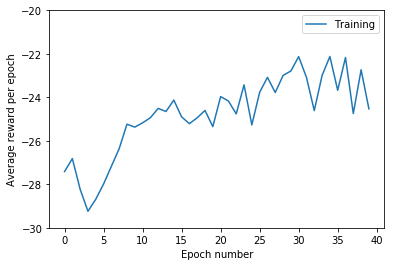

In [62]:
plt.plot(episode_reward_train[1:], label='Training')
# plt.plot(episode_reward_test, label='Testing')
# plt.plot(episode_reward_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average reward per epoch')
plt.ylim(-30, -20)
plt.legend()

last_n = 10
train_avg = np.mean(np.array(episode_reward_train)[-last_n:])
# test_avg = np.mean(np.array(episode_reward_test)[-last_n:])
# rand_avg = np.mean(np.array(episode_reward_rand)[-last_n:])

print("Average reward for last", last_n, "epochs in training:", round(train_avg, 3))
# print("Average reward for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average reward for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

Average length for last 10 epochs in training: 21.137
Average length for last 10 epochs in testing: 23.95


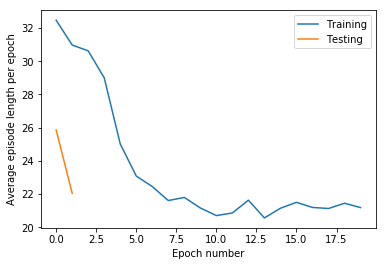

In [33]:
plt.plot(episode_length_train, label='Training')
plt.plot(episode_length_test, label='Testing')
# plt.plot(episode_length_rand, label='Testing rand')

plt.xlabel('Epoch number')
plt.ylabel('Average episode length per epoch')
plt.legend()

train_avg = np.mean(np.array(episode_length_train)[-last_n:])
test_avg = np.mean(np.array(episode_length_test)[-last_n:])
# rand_avg = np.mean(np.array(episode_length_rand)[-last_n:])

print("Average length for last", last_n, "epochs in training:", round(train_avg, 3))
print("Average length for last", last_n, "epochs in testing:", round(test_avg, 3))
# print("Average length for last", last_n, "epochs in testing random policy:", round(rand_avg, 3))

In [43]:
xs = range(100)

policy = DQN_make_epsilon_greedy_policy(estimator, 0, actions)
ys = [np.random.choice(np.arange(actions), p=policy(i)) for i in xs]

plt.scatter(xs, ys)
plt.xlabel("State")
plt.ylabel("Actions")

TypeError: 'int' object is not iterable

In [183]:
state = 256

estimator.predict(state)

array([-1.08106339, -0.98628557, -1.00681334, -1.14676465, -1.01414276,
       -1.03920674, -0.95491733, -0.97960388, -1.11900149, -0.96197248,
       -0.98531593, -0.96607036, -1.0109629 , -0.97665428, -0.99197745,
       -1.00057868, -1.02822085, -0.95329277, -0.98146715, -0.98885396,
        0.        , -0.98633782, -1.04502484, -1.07116725, -0.95054096,
       -0.96212715, -1.0541073 , -1.00578894, -0.93820797, -0.95318104,
       -1.0228148 , -1.03815234, -0.97108546, -0.96719226, -1.02232722,
       -1.0172402 , -1.03255231, -1.05948592, -1.03425613, -1.0285922 ,
       -0.97348332])

Text(0,0.5,'Q-value')

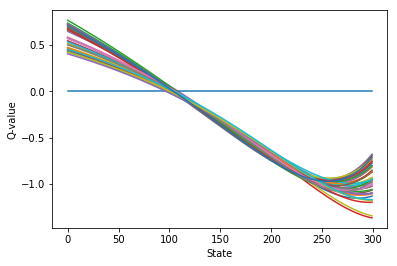

In [185]:
# plt.figure(figsize=(10, 12))

q_values = np.array([estimator.predict(s) for s in xs])

for i in range(actions):
    plt.plot(q_values[:, i], label='Action '+str(i))

# plt.legend()
plt.xlabel('State')
plt.ylabel('Q-value')

Testing time taken to use a heuristic

In [88]:
import time

heuristic = jw_2
directory = '../Tests/SATLIB_20/'
files = os.listdir(directory)
files = list(map(lambda x: os.path.join(directory, x), files))

split = int(len(files) * 0.1)
training_files = files[:split]

total_time = 0

for file in training_files:
    env = Env(file)
    env.reset()
    a, b, c = env.state
    
    s = time.time()
    for _ in range(1000):
        heuristic(a, b)
    e = time.time()
    total_time += (e - s) / 1000
    
print(total_time / split)

0.00011689195871353151


In [ ]:
{0: 'maxo', 1: 'moms', 2: 'mams', 3: 'jw', 4: 'jw_2', 5: 'bohm'}